In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1kHY0pEoEYIL0BFBlbxDcyC3Qfhmvmie5"})
downloaded.GetContentFile('train_new.csv')

downloaded = drive.CreateFile({'id':"1U4dA8-LTKrnaq85BIoILtnpa2XdD03KA"})
downloaded.GetContentFile('test_new.csv')

# Data

In [ ]:
import pandas as pd

data = pd.read_csv('train_new.csv')
test = pd.read_csv('test_new.csv')
data.shape, test.shape

((44046, 6), (4574, 6))

In [ ]:
data.head()

,Artist,Language,Lyrics,Genre,n_words,GenreY
0,linkin park,en,aching head echoes buzzing noises voices black...,Metal,68,3
1,dusty springfield,en,loved touch love light love return joys dreami...,Folk,54,1
2,lightnin' hopkins,en,lordy lord lordy lord hurts bad baby ain gonna...,Folk,58,1
3,secret garden,en,love life time hear music soul leave widest oc...,Pop,35,4
4,forfun,pt,smica eletromagn tica distribui sorrisos canal...,Rock,71,5


In [ ]:
test.head()

,Artist,Language,Lyrics,Genre,n_words,GenreY
0,the-elwins,en,cold hands sharpen axe criminal town gonna hur...,Indie,49,0
1,bullet-for-my-valentine,en,ready time war break fucking doors smash windo...,Metal,79,3
2,dream-street,en,change color hair yeah pairs shoes wear lot ch...,Pop,69,4
3,craig-cardiff,en,lost lost flood broke exposed love sleepy head...,Indie,27,0
4,carnal-forge,en,broken hopes lies blind penetrates eyes escape...,Metal,85,3


# 2.3 Tokenizing with Bert

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
from tensorflow.keras.preprocessing import sequence

def getTokens(df):
  lyrics = df['Lyrics'].values
  X = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(lyric)) for lyric in lyrics]
  return X

def getMax(X):
  max = 0
  for x in X:
    lenx = len(x)
    if (max < lenx):
      max = lenx
  return max

def padSeq(X, max):
  X = sequence.pad_sequences(X, maxlen=max, padding='post')
  return X

In [ ]:
X_train = getTokens(data)
getMax(X_train)

1198

In [ ]:
X_test = getTokens(test)
getMax(X_test)

770

In [ ]:
X_train = padSeq(X_train, 1200)
X_test  = padSeq(X_test,  1200)
type(X_train), type(X_test)

(numpy.ndarray, numpy.ndarray)

In [ ]:
y_train = data['GenreY'].values
y_test  = test['GenreY'].values
type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray)

In [ ]:
#y_train = pd.get_dummies(data['Genre']).values
#y_test  = pd.get_dummies(test['Genre']).values
#type(y_train), type(y_test)

# Modeling CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D
import tensorflow as tf

In [ ]:
#The maximum number of words to be used. (most frequent)
max_features   = len(tokenizer.vocab) + 1
# Max number of words in each lyric
maxlen         = 1200
# value recommended by documentation
embedding_dims = 500

# Defining a function
def create_cnn_text():
  #  Intializate the model
  model = Sequential()
  #Embeding by the input variable
  model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
  #Convo layer (Convo + ReLU)
  #  1 dimensional CNN | Conv1D, VALID : Don't apply any padding,  
  #  a cnn filter(or "channels" as it's often called) is the Z dimension) of 100  
  #  and kernel size (is the X * Y dimensions) of 2
  model.add(Conv1D(100, 2, padding='valid',activation='relu'))
  #  1 dimensional CNN | Conv1D, VALID : Don't apply any padding,  
  #  a cnn filter(or "channels" as it's often called) is the Z dimension) of 100  
  #  and kernel size (is the X * Y dimensions) of 3
  model.add(Conv1D(100, 3, padding='valid',activation='relu'))

  #Pooling Layer where hyperparameters: stride and size no specified because it is Global 
  # and not a MaxPooling 
  model.add(GlobalMaxPooling1D())
  # The activitaion function selected is Relu
  model.add(Dense(16, activation='relu'))
  # The dropout technique where randomly selected neurons are ignored during training.
  model.add(Dropout(rate=0.1))

  # Output Layer with a Softmax activation function(for multi-classification task) and 6 labels as output
  model.add(Dense(6, activation='softmax'))
  # Optimization is ADAM and loss function  sparse as no ending has been done. 
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
text_model = create_cnn_text()
history    = text_model.fit(X_train, y_train, batch_size=32, 
                            epochs=5, validation_split=0.35)

Epoch 1/5
964/964 [==============================] - 1376s 1s/step - loss: 1.6013 - accuracy: 0.3418 - val_loss: 1.3547 - val_accuracy: 0.4790
Epoch 2/5
964/964 [==============================] - 1375s 1s/step - loss: 1.2001 - accuracy: 0.5431 - val_loss: 1.2988 - val_accuracy: 0.5054
Epoch 3/5
964/964 [==============================] - 1380s 1s/step - loss: 0.9234 - accuracy: 0.6648 - val_loss: 1.3621 - val_accuracy: 0.5084
Epoch 4/5
964/964 [==============================] - 1380s 1s/step - loss: 0.6816 - accuracy: 0.7576 - val_loss: 1.4916 - val_accuracy: 0.5008
Epoch 5/5
964/964 [==============================] - 1378s 1s/step - loss: 0.4830 - accuracy: 0.8368 - val_loss: 1.7189 - val_accuracy: 0.5020


In [ ]:
import matplotlib.pyplot as plt

def plot_history(train, valid):
  plt.title('Loss')
  plt.plot(train, label='train')
  plt.plot(valid, label='validation')
  plt.legend()
  plt.show()

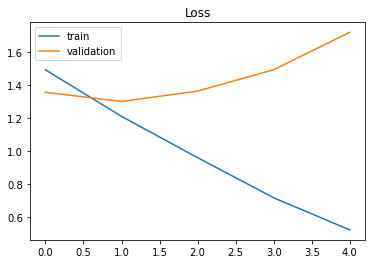

In [ ]:
plot_history(history.history['loss'], history.history['val_loss'])

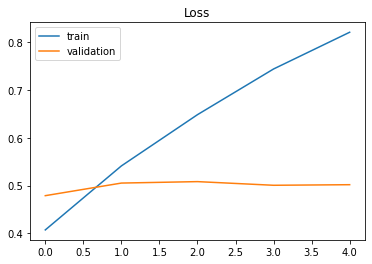

In [ ]:
plot_history(history.history['accuracy'], history.history['val_accuracy'])

In [ ]:
loss, accuracy = text_model.evaluate(X_test, y_test)
print(f'Loss:     {loss}')
print(f'Accuracy: {accuracy}')

143/143 [==============================] - 34s 238ms/step - loss: 2.1542 - accuracy: 0.3843
Loss:     2.1542232036590576
Accuracy: 0.3843463063240051


In [ ]:
text_model.save('task1_cnn_bert')

INFO:tensorflow:Assets written to: task1_cnn_bert/assets


INFO:tensorflow:Assets written to: task1_cnn_bert/assets


In [ ]:
ls -R task1_cnn_bert/

task1_cnn_bert/:
assets/  saved_model.pb  variables/

task1_cnn_bert/assets:

task1_cnn_bert/variables:
variables.data-00000-of-00001  variables.index


In [ ]:
from google.colab import files
files.download('task1_cnn_bert/saved_model.pb')
files.download('task1_cnn_bert/variables/variables.index')
files.download('task1_cnn_bert/variables/variables.data-00000-of-00001')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Modeling RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GlobalMaxPooling1D, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#The maximum number of words to be used. (most frequent)
max_features   = len(tokenizer.vocab) + 1
# Max number of words in each lyric
maxlen         = 1200
# value recommended by documentation
embedding_dims = 500

# Defining a function
def create_rnn_text():
  #Intializate the model
  model = Sequential()
  #Embeding by the input variable
  model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
  #Pooling Layer where hyperparameters: stride and size no specified because it is Global 
  # and not a MaxPooling 
  model.add(GlobalAveragePooling1D())
  #  100 neurons in the FIRST hidden layer with activitaion function selected "Relu"
  model.add(Dense(200, activation='relu'))
  # Output Layer with a Softmax activation function(for multi-classification task) and 6 labels as output
  model.add(Dense(6, activation='softmax'))
  # Optimization is ADAM and loss function "sparse" as no encoding has been done
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
  return model

In [ ]:
text_model2 = create_rnn_text()
history     = text_model2.fit(X_train, y_train, batch_size=32, epochs=12, validation_split=0.1)

Epoch 1/12
1239/1239 [==============================] - 863s 696ms/step - loss: 1.7356 - accuracy: 0.2340 - val_loss: 1.4651 - val_accuracy: 0.4129
Epoch 2/12
1239/1239 [==============================] - 845s 682ms/step - loss: 1.3982 - accuracy: 0.4510 - val_loss: 1.3496 - val_accuracy: 0.4883
Epoch 3/12
1239/1239 [==============================] - 840s 678ms/step - loss: 1.2352 - accuracy: 0.5322 - val_loss: 1.3145 - val_accuracy: 0.5037
Epoch 4/12
1239/1239 [==============================] - 840s 678ms/step - loss: 1.1162 - accuracy: 0.5837 - val_loss: 1.3336 - val_accuracy: 0.5062
Epoch 5/12
1239/1239 [==============================] - 838s 676ms/step - loss: 1.0236 - accuracy: 0.6262 - val_loss: 1.3456 - val_accuracy: 0.5217
Epoch 6/12
1239/1239 [==============================] - 845s 682ms/step - loss: 0.9382 - accuracy: 0.6611 - val_loss: 1.4339 - val_accuracy: 0.5137
Epoch 7/12
1239/1239 [==============================] - 843s 680ms/step - loss: 0.8788 - accuracy: 0.6831 - val_

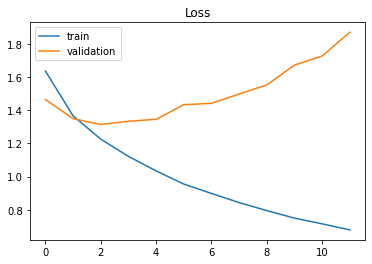

In [ ]:
plot_history(history.history['loss'], history.history['val_loss'])

The point of intersection in the loss curve for validation and test is at epoch 1 of the training.

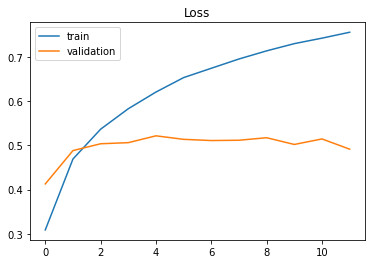

In [ ]:
plot_history(history.history['accuracy'], history.history['val_accuracy'])

The point of intersection in the accuracy curve for validation adn test is at epoch 1 of the training where the overfitting starts to take place.

In [ ]:
loss, accuracy = text_model2.evaluate(X_test, y_test)
print(f'Loss:     {loss}')
print(f'Accuracy: {accuracy}')

143/143 [==============================] - 5s 35ms/step - loss: 2.1369 - accuracy: 0.4018
Loss:     2.136852502822876
Accuracy: 0.40183645486831665


In [ ]:
text_model2.save('task1_rnn_bert.h5')

In [ ]:
from google.colab import files
files.download('task1_rnn_bert.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>